In [1]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [2]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [3]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
states
us
election
counties


In [4]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [5]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0
1,2020-01-25,Cook,Illinois,17031.0,1,0
2,2020-01-26,Cook,Illinois,17031.0,1,0
3,2020-01-27,Cook,Illinois,17031.0,1,0
4,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
267,2020-10-17,Cook,Illinois,17031.0,162220,5350
268,2020-10-18,Cook,Illinois,17031.0,163912,5357
269,2020-10-19,Cook,Illinois,17031.0,165198,5364
270,2020-10-20,Cook,Illinois,17031.0,166457,5369


In [6]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
267,2020-10-17,Cook,Illinois,162220
268,2020-10-18,Cook,Illinois,163912
269,2020-10-19,Cook,Illinois,165198
270,2020-10-20,Cook,Illinois,166457


In [7]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0
...,...,...,...,...,...,...,...
267,2020-10-17,Illinois,Cook,1575.0,162220,10.0,5350
268,2020-10-18,Illinois,Cook,1692.0,163912,7.0,5357
269,2020-10-19,Illinois,Cook,1286.0,165198,7.0,5364
270,2020-10-20,Illinois,Cook,1259.0,166457,5.0,5369


In [8]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0
...,...,...,...,...,...,...,...
20974,2020-10-17,Illinois,Woodford,0.0,549,0.0,11
20975,2020-10-18,Illinois,Woodford,0.0,549,0.0,11
20976,2020-10-19,Illinois,Woodford,11.0,560,0.0,11
20977,2020-10-20,Illinois,Woodford,5.0,565,4.0,15


In [9]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
654408,2020-10-17,Wyoming,Weston,7.0,88,0.0,0
654409,2020-10-18,Wyoming,Weston,5.0,93,0.0,0
654410,2020-10-19,Wyoming,Weston,6.0,99,0.0,0
654411,2020-10-20,Wyoming,Weston,2.0,101,0.0,0


In [10]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
654408,2020-10-17,Wyoming,Weston,7.0,88,0.0,0
654409,2020-10-18,Wyoming,Weston,5.0,93,0.0,0
654410,2020-10-19,Wyoming,Weston,6.0,99,0.0,0
654411,2020-10-20,Wyoming,Weston,2.0,101,0.0,0


In [11]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
654408,2020-10-17,Wyoming,Weston,7.0,88,4.285714,0.0,0,0.0
654409,2020-10-18,Wyoming,Weston,5.0,93,5.000000,0.0,0,0.0
654410,2020-10-19,Wyoming,Weston,6.0,99,5.857143,0.0,0,0.0
654411,2020-10-20,Wyoming,Weston,2.0,101,5.571429,0.0,0,0.0


In [50]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
267,2020-10-17,Illinois,Cook,1575.0,162220,1243.714286,10.0,5350,7.428571
268,2020-10-18,Illinois,Cook,1692.0,163912,1341.857143,7.0,5357,8.142857
269,2020-10-19,Illinois,Cook,1286.0,165198,1375.857143,7.0,5364,8.571429
270,2020-10-20,Illinois,Cook,1259.0,166457,1390.142857,5.0,5369,7.714286


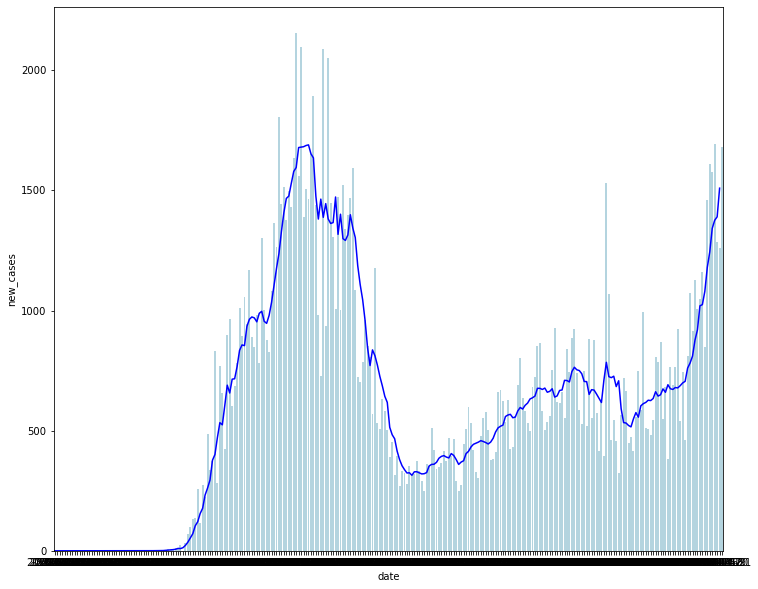

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


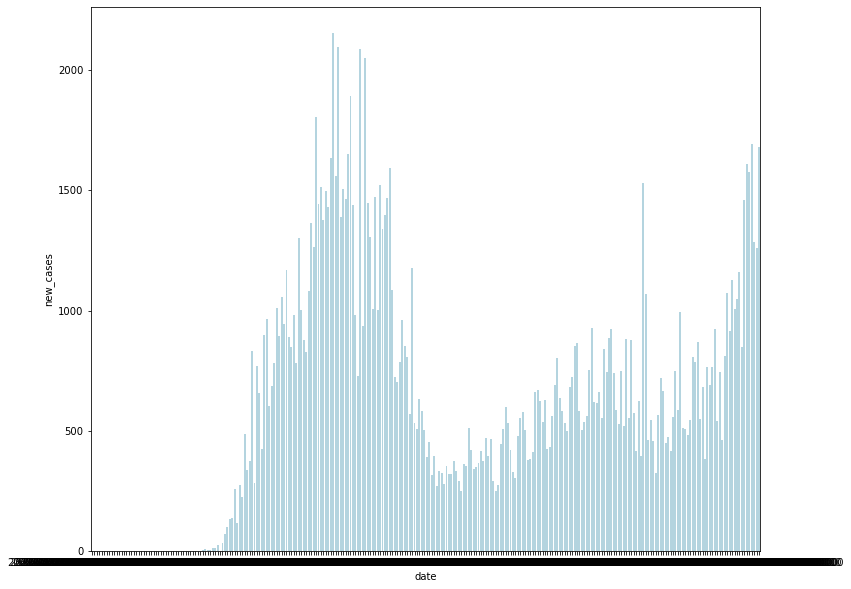

In [44]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

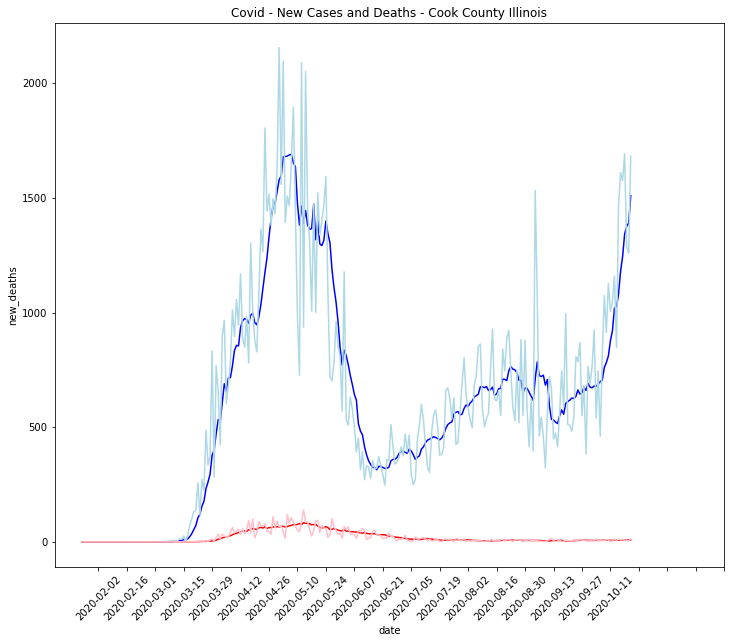

In [79]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');

# plt.plot(cook['date'],cook['7-day_avg_new']
